# Calculating Cumulative Impact Probability Difference Distribution Between NASA and ESA

In [1]:
# Matplotlib to plot a distribution of cumulative probabilities
import matplotlib.pyplot as plt

# Astropy to read the data and put it in a QTable
import astropy.units as u
from astropy.table import QTable
from astropy.table import join

# Np for data manipulation (np.vectorize etc.)
import numpy as np

In [2]:
# Reading csv file for NASA's data
nasa_table = QTable.read('./nasa_ipcum.ecsv', 
                         format='ascii.ecsv',
                         delimiter = ' ')
nasa_table[0:3]

last_obs,v_inf,ps_max,fullname,ip,des,h,range,last_obs_jd,n_imp,ps_cum,ts_max,diameter,id
str15,str17,str6,str24,str20,str10,str5,str9,str12,int64,str6,object,str7,str8
1979-12-15,23.7606234552547,-2.99,(1979 XB),8.515158e-07,1979 XB,18.54,2056-2113,2444222.5,4,-2.69,0,0.66,bJ79X00B
2022-05-23,15.5694051293592,-5.79,(2022 KK2),0.0001203297828,2022 KK2,28.45,2060-2122,2459722.5,33,-5.59,0,0.0069,bK22K02K
2000-10-03,1.35802744453748,-3.11,(2000 SG344),0.002743395186,2000 SG344,24.79,2069-2122,2451820.5,300,-2.77,0,0.037,bK00SY4G


In [3]:
# Checking to see that all of the data from Nasa successfully got loaded
len(nasa_table)

2067

In [4]:
# Reading csv file for ESA's data
esa_table = QTable.read('./esa_ipcum.ecsv', 
                         format='ascii.ecsv',
                         delimiter = ' ')
esa_table[0:3]

object_name,diameter_m,estimated_flag,vi_max_date,ip_max,ps_max,ts,vel_km_s,years,ip_cum,ps_cum
str26,str4,str1,str16,str8,str6,str1,str5,str9,str8,str6
2023VD3,14,*,2034-11-08 17:08,2.35E-3,-2.67,0,21.01,2034-2039,2.35E-3,-2.67
2008JL3,30,*,2027-05-01 09:05,1.49E-4,-2.73,0,14.01,2027-2122,1.61E-4,-2.73
1979XB,500,*,2056-12-12 21:38,2.34E-7,-2.82,0,27.54,2056-2113,7.34E-7,-2.70


In [5]:
# Checking to see that all of the data from Esa successfully got loaded
len(esa_table)

1908

In [6]:
# Renaming the columns of each table so the the object designation matches (so it can be used as a key) and the cumulative probs specify the dataset
nasa_table.rename_columns(['ip', 'des'], ['IP cum NASA', 'Object Designation'])
esa_table.rename_columns([ 'ip_cum', 'object_name'], ['IP cum ESA', 'Object Designation'])

In [7]:
def to_floats(string_column):
    return float(string_column)

In [8]:
vto_floats = np.vectorize(to_floats)

In [9]:
nasa_table['IP cum NASA'] = vto_floats(nasa_table['IP cum NASA'])
nasa_table['v_inf'] = vto_floats(nasa_table['v_inf'])
esa_table['IP cum ESA'] = vto_floats(esa_table['IP cum ESA'])

In [10]:
# Creating a subset of NASA's data with just designation (key) and cumulative probabilities and velocity at infinity v_inf (values)
asteroid_list_nasa = nasa_table['Object Designation',  'v_inf', 'IP cum NASA']
asteroid_list_nasa[0:4]

Object Designation,v_inf,IP cum NASA
str10,float64,float64
1979 XB,23.7606234552547,8.515158e-07
2022 KK2,15.5694051293592,0.0001203297828
2000 SG344,1.35802744453748,0.002743395186
2012 VS76,11.4626328606267,1.9442009e-05


In [11]:
# The designations for ESA have no spaces, so need to remove them from NASA's data
def remove_spaces(array_w_spaces):
        return array_w_spaces.replace(" ","")

In [12]:
# Vectorizing the function so that it can apply to every entry in the designation column
vremove_spaces = np.vectorize(remove_spaces)

In [13]:
# Removing spaces from NASA's data
asteroid_list_nasa['Object Designation'] = vremove_spaces(asteroid_list_nasa['Object Designation'])
asteroid_list_nasa[0:4]

Object Designation,v_inf,IP cum NASA
str9,float64,float64
1979XB,23.7606234552547,8.515158e-07
2022KK2,15.5694051293592,0.0001203297828
2000SG344,1.35802744453748,0.002743395186
2012VS76,11.4626328606267,1.9442009e-05


In [14]:
# Creating a subset of ESA's data with just designation (key) and cumulative probabilities (values)
asteroid_list_esa = esa_table['Object Designation', 'IP cum ESA']
asteroid_list_esa[0:4]

Object Designation,IP cum ESA
str26,float64
2023VD3,0.00235
2008JL3,0.000161
1979XB,7.34e-07
2000SG344,0.00282


In [15]:
# No longer applicable because new dataset does not have probabilities as fractions
# The probabilities are fractions displayed as strings, so need to convert them to floats
# def convert_frac_to_float(fraction_array):
#         try:
#             num, denom = fraction_array.split('/')
#         except ValueError:
#             return None
#         return float(num) / float(denom)

In [16]:
# # Vectorizing the function so it applies to each entry in the cumulative probability column
# vconvert_frac_to_float = np.vectorize(convert_frac_to_float)

In [17]:
# # Removing the spaces from ESA just in case, and converting each fraction string into a float
# asteroid_list_esa['Object Designation'] = vremove_spaces(asteroid_list_esa['Object Designation'])
# asteroid_list_esa['IP cum ESA'] = vconvert_frac_to_float(asteroid_list_esa['IP cum ESA'])
# asteroid_list_esa[0:4]

In [18]:
# Joining the two datasets together by the key Object Designation - if an asteroid only appears in one dataset it does not get put into this joined table
asteroid_common_list = join(asteroid_list_nasa, asteroid_list_esa, keys = 'Object Designation')
asteroid_common_list[0:4]

Object Designation,v_inf,IP cum NASA,IP cum ESA
str26,float64,float64,float64
1979XB,23.7606234552547,8.515158e-07,7.34e-07
1991BA,16.7227981196217,4.1830306e-06,5.29e-06
1993HP1,9.73497672753312,5.586e-08,2.24e-07
1993KA2,23.2,4.177e-08,3.52e-08


In [19]:
# Checking how many asteroids are in both datasets
len(asteroid_common_list)

1725

In [20]:
# This must mean that some asteroids in ESA's dataset aren't in NASA's, even though ESA has less overall asteroids.

In [54]:
asteroid_common_list['maximum cum IP'] = np.maximum(asteroid_common_list['IP cum NASA'], asteroid_common_list['IP cum ESA'])
asteroid_common_list['IP cum difference'] = asteroid_common_list['IP cum NASA'] - asteroid_common_list['IP cum ESA']
asteroid_common_list['abs val IP cum difference'] = np.abs(asteroid_common_list['IP cum difference'])
asteroid_common_list['relative cum IP'] = (asteroid_common_list['abs val IP cum difference'] / asteroid_common_list['maximum cum IP'])
asteroid_common_list[0:4]


Object Designation,v_inf,IP cum NASA,IP cum ESA,maximum cum IP,IP cum difference,abs val IP cum difference,relative cum IP
str26,float64,float64,float64,float64,float64,float64,float64
1979XB,23.7606234552547,8.515158e-07,7.34e-07,8.515158e-07,1.1751579999999997e-07,1.1751579999999997e-07,0.13800777390155294
1991BA,16.7227981196217,4.1830306e-06,5.29e-06,5.29e-06,-1.1069694000000005e-06,1.1069694000000005e-06,0.20925697542533092
1993HP1,9.73497672753312,5.586e-08,2.24e-07,2.24e-07,-1.6814e-07,1.6814e-07,0.750625
1993KA2,23.2,4.177e-08,3.52e-08,4.177e-08,6.570000000000005e-09,6.570000000000005e-09,0.1572899209959302


In [22]:
# def interactive_hist(grid_values):
#     import ipywidgets as wd
#     gridsize_slider = wd.IntSlider(
#         value = 100,
#         min = 0,
#         max = 100,
#         step = 0.5)
    
#     def plot():
#         fig, ax = plt.subplot_mosaic('''ABC''', figsize = (15,5), constrained_layout = True)
#         ax['A'].set_xlabel("Impact Probabilities for NASA")
#         ax['A'].set_ylabel("Amount")
#         ax['B'].set_xlabel("Impact Probabilities for ESA")
#         ax['B'].set_ylabel("Amount")
#         ax['C'].set_xlabel("Cumulative Impact Probability Differences")
#         ax['C'].set_ylabel("Amount")
#         ax['A'].hist(asteroid_list_esa['IP cum ESA'], bins = 10, histtype = "stepfilled", facecolor = "red")
#         ax['B'].hist(asteroid_list_nasa['IP cum NASA'], bins = 10, histtype = "stepfilled", facecolor = "blue")
#         ax['C'].hist(asteroid_common_list['abs val IP cum difference'], bins = 10, histtype = "stepfilled", facecolor = "purple")

#         ax['A'].set_yscale("log")
#         ax['B'].set_yscale("log")
#         ax['C'].set_yscale("log")

#         return plot

#     wd.interactive(plot, grid_values = gridsize_slider)

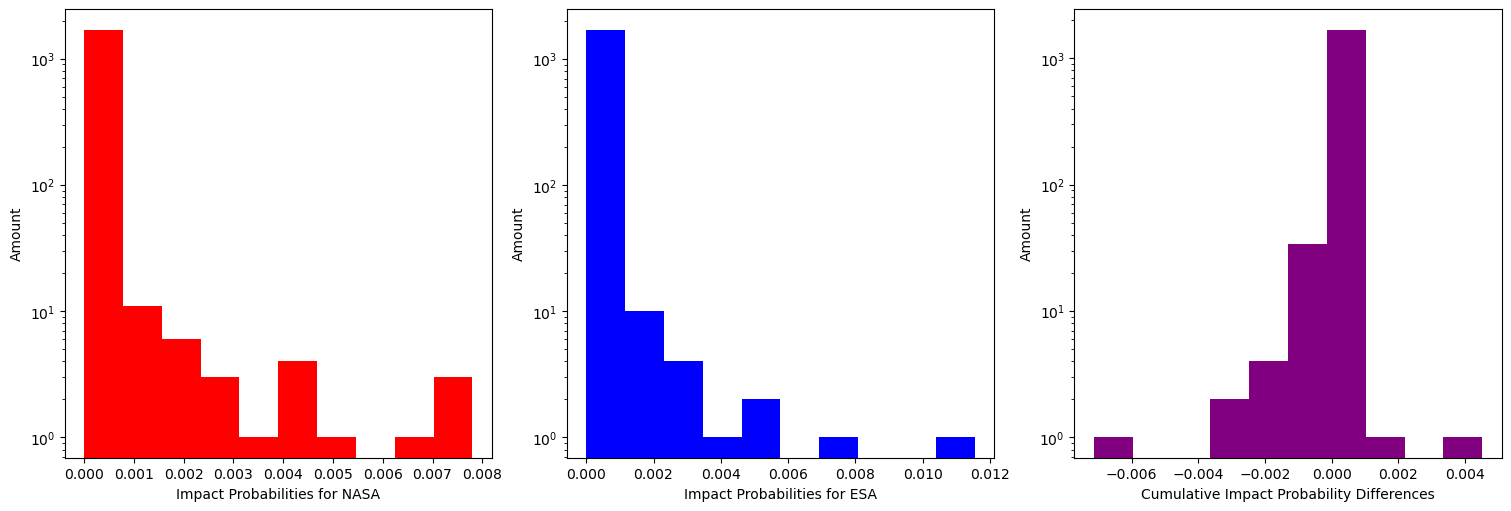

In [23]:

        fig, ax = plt.subplot_mosaic('''ABC''', figsize = (15,5), constrained_layout = True)
        ax['A'].set_xlabel("Impact Probabilities for NASA")
        ax['A'].set_ylabel("Amount")
        ax['B'].set_xlabel("Impact Probabilities for ESA")
        ax['B'].set_ylabel("Amount")
        ax['C'].set_xlabel("Cumulative Impact Probability Differences")
        ax['C'].set_ylabel("Amount")
        ax['A'].hist(asteroid_common_list['IP cum ESA'], bins = 10, histtype = "stepfilled", facecolor = "red")
        ax['B'].hist(asteroid_common_list['IP cum NASA'], bins = 10, histtype = "stepfilled", facecolor = "blue")
        ax['C'].hist(asteroid_common_list['IP cum difference'], bins = 10, histtype = "stepfilled", facecolor = "purple")

        ax['A'].set_yscale("log")
        ax['B'].set_yscale("log")
        ax['C'].set_yscale("log")


In [52]:
# Defining a nested function to plot the Hess diagram (necessary to create a slider)
def plot_hess(x, y, gridsize_val=200):
        
    fig, ax = plt.subplots(figsize=(9,4))

    init_hxb = ax.hexbin(np.log10(x), y, gridsize=gridsize_val, bins='log', cmap='inferno')

    ax.set_xlabel('Log10(Cum IP) (Maximum Between NASA and ESA)', 
                     fontfamily = 'serif',
                     fontsize = 15)
    ax.set_ylabel('Relative IP Difference (Percentage)', 
                     fontfamily = 'serif',
                     fontsize = 15)
    ax.set_title('Log10(Cum IP) vs Relative IP Difference', 
                     fontfamily = 'serif',
                     fontsize = 15)

    ax.set_xscale('linear')
    
    ax.tick_params(axis='both', which='major', labelsize = 12)
        
        # Returns the plot generated with these parameters
    
    return plt.show()

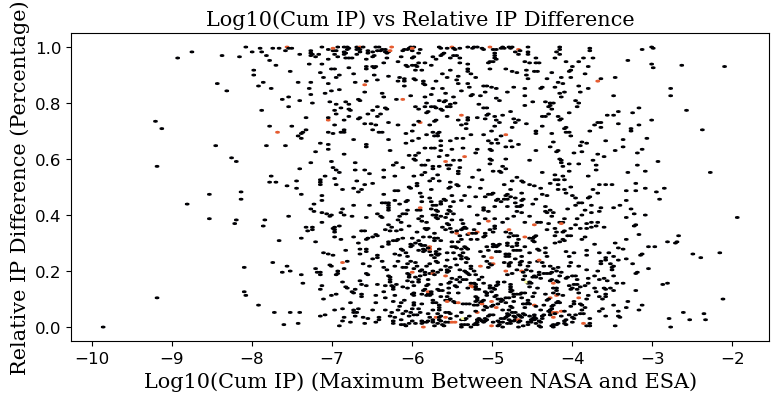

In [55]:
plot_hess(asteroid_common_list['maximum cum IP'] , asteroid_common_list['relative cum IP'])